<a href="https://colab.research.google.com/github/iamvarada/colab_ML/blob/main/fuel_predication_with_auto_mpg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
## Regression problem:

# Goal : To predict the fuel efficiency of a car

# Dataset: Auto MPG dataset built on fuel efficiency of late 1970s and 1980s automobiles


In [2]:
!pip install seaborn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [28]:
from __future__ import absolute_import, division, print_function

import pathlib

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.12.0


In [4]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv(url, names=column_names,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)

In [7]:
dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [8]:
# clean the data

dataset.isna().sum() # check for empty columns


MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [9]:
dataset = dataset.dropna() # drop empty columns (one way of handling this as there are only 6 rows)

In [10]:
# 'Origin' is categorical column so need to convert into one-hot column

# separate columns for each country of origin
origin = dataset.pop('Origin')
dataset['USA'] = (origin == 1) * 1.0
dataset['Europe'] = (origin == 2) * 1.0
dataset['Japan'] = (origin == 3) * 1.0
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1.0,0.0,0.0


In [12]:
# Split into training and test dataset

train_dataset = dataset.sample(frac = 0.8, random_state = 0) # 80% train, 20% test
test_dataset = dataset.drop(train_dataset.index)

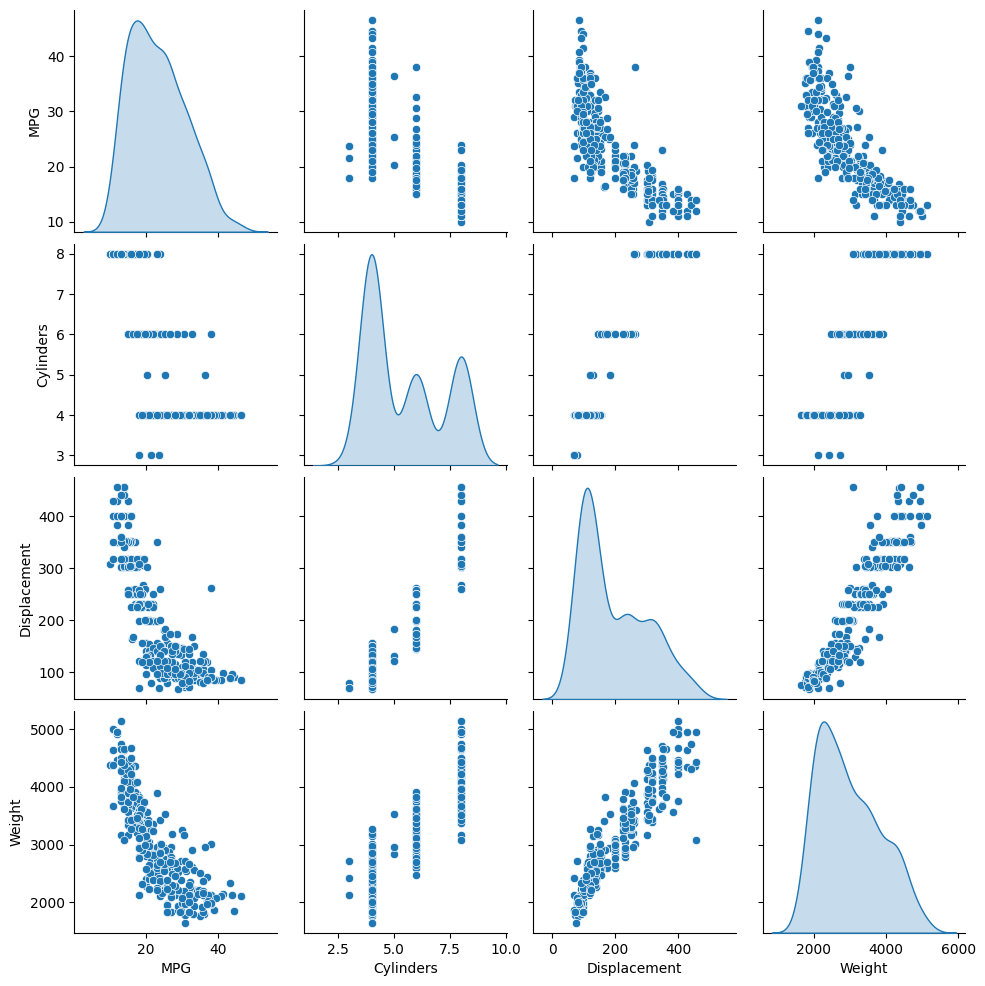

In [13]:
# inspect data
sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind = "kde")


In [15]:
# checking general statistics of the data

train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()
train_stats

# ranges very diff which is not that useful

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


In [41]:
# drop the label (aka target value) which we are trying to predict from the dataset and store it in labels

train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

KeyError: ignored

In [17]:
# Normalize the data to compensate for difference in ranges of the difference columns in the input data

def norm(x):
  return (x - train_stats['mean']) / train_stats['std'] # z-score

normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [20]:
from keras.api._v2.keras import activations
# Build the model

def build_model():
  model = keras.Sequential([
      layers.Dense(64, activation = tf.nn.relu, input_shape=[len(train_dataset.keys())]),
      layers.Dense(64, activation = tf.nn.relu),
      layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001) # learning rate, alpha = 0.001

  model.compile(loss = 'mse',
                optimizer = optimizer,
                metrics = ['mae', 'mse'])
  
  return model

In [22]:
# build the model

model = build_model()

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 64)                640       
                                                                 
 dense_7 (Dense)             (None, 64)                4160      
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


In [25]:
# Train the model

# just a function to print a dot after every epoch so that we know the model is training
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 100

history = model.fit(
    normed_train_data, train_labels,
    epochs = EPOCHS, validation_split = 0.2, verbose=0, # also splitting validation set from the training dataset
    callbacks = [PrintDot()]
)



....................................................................................................

In [26]:
# check the training results

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
95,5.220438,1.564050,5.220438,9.076286,2.222468,9.076286,95
96,5.281686,1.613639,5.281686,8.685804,2.266764,8.685804,96
97,5.164979,1.574252,5.164979,8.700634,2.267688,8.700634,97
98,5.146007,1.567498,5.146007,8.898790,2.303038,8.898790,98
99,5.502343,1.621676,5.502343,8.668958,2.227080,8.668958,99


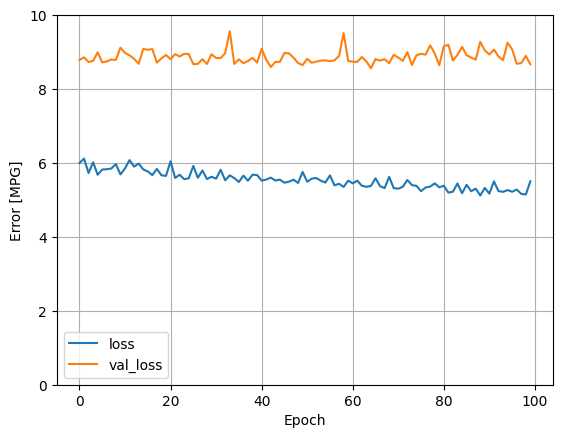

In [29]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  # plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)


plot_loss(history) # !! overfitting !!


........................................................................

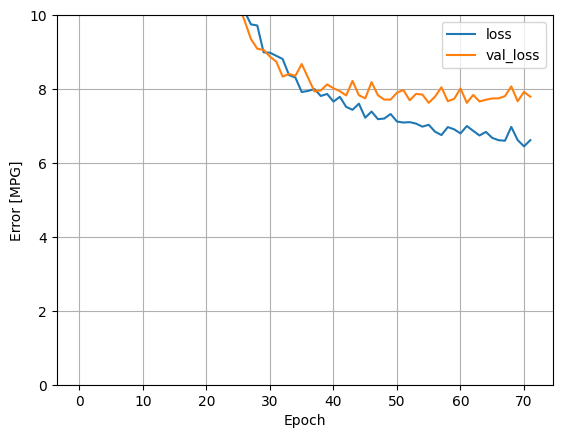

In [33]:
# Implement early stopping (stop before the loss gets worse) and check the loss progression

model = build_model()

# Patience parameter = amouint of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10) # we are applying it over validation loss here

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS, 
                    validation_split = 0.2, verbose = 0, callbacks=[early_stop, PrintDot()])

plot_loss(history)

In [37]:
# check training metrics

loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=0)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

Testing set Mean Abs Error:  1.90 MPG


3/3 [==============================] - 0s 3ms/step


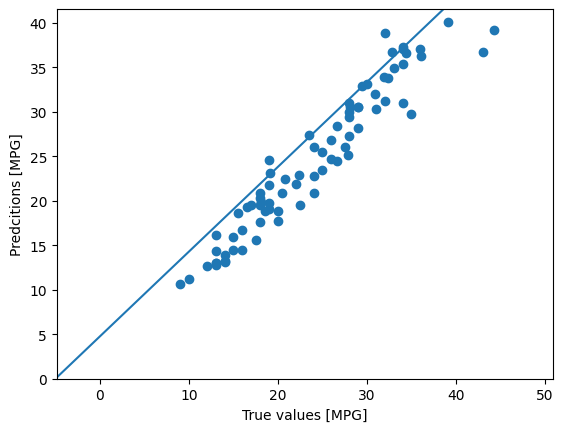

In [40]:
# Make predictions now

test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True values [MPG]')
plt.ylabel('Predcitions [MPG]')
plt.axis('equal')
plt.xlim([0, plt.xlim()[1]])
plt.ylim([0, plt.ylim()[1]])
plt.plot([-110, 100], [-100, 100])

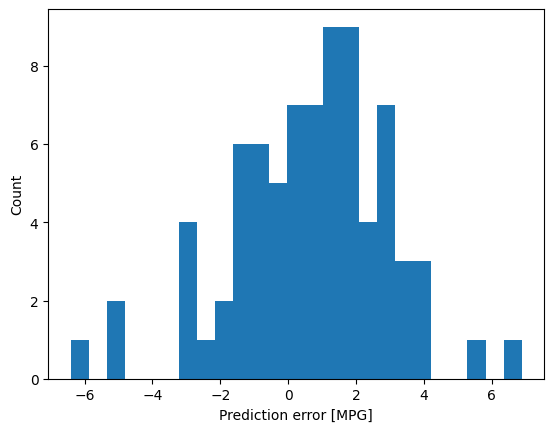

In [43]:
# Plot the error

error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction error [MPG]")
_ = plt.ylabel("Count")